In [18]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [19]:
df = pd.read_csv('reviews.csv')
df.isnull().values.any() # checks if data file have any null values
df.head()

,reviews,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
def preprocess(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
  text = re.sub('[\W]+', ' ', text.lower()) +\
      ' '.join(emoticons).replace('-', '')
  return text


In [5]:
X = []
sentences = list(df['reviews'])
for sen in sentences:
    X.append(preprocess(sen))
y = df['sentiment']

# Train( 80 ) Test( 20 ) Split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding Layer ( For converting textual data into numeric data )

* First layer in DL model in Keras

In [69]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(len(X_train[1]))
print(len(X_test[1]))

158
233


In [70]:
print(X_train[2])

[10, 202, 29, 1, 89, 348, 19, 9, 123, 210, 1, 63, 1164, 9, 50, 132, 44, 7, 6, 11, 2501, 9, 155, 21, 969, 5, 65, 7, 71, 69, 359, 3, 873, 773, 8, 358, 2, 285, 8, 1, 300, 41, 1738, 39, 2930, 1515, 51, 1, 243, 60, 376, 10, 412, 4, 2502, 6, 3, 905, 742, 95, 97, 195, 19, 1, 815, 323, 22, 135, 234, 1, 15, 548, 44, 163, 1645, 5, 988, 1, 63, 669, 35, 50, 29, 919, 8, 10, 19, 24, 146, 35, 438, 66, 2801, 2, 181, 5, 118, 135, 32, 232, 167, 48, 4, 1, 2656, 219, 3, 279, 232, 27, 90, 34, 219, 617, 4, 10, 18, 9, 797, 7, 1, 2656, 592, 69, 23, 1767, 8, 99, 95, 14, 7, 6, 7, 6, 41, 3, 1605, 196, 5, 2, 5, 29, 3, 173, 4, 786, 10, 19, 30, 99, 2128]


In [71]:
# padding process 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [72]:
print(len(X_train[1]))
print(len(X_test[1]))

100
100


In [73]:
print(vocab_size) # number of unique words in dataset

94320


In [74]:
# using GloVe for creating feature matrix
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [75]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [76]:
len(embedding_matrix)

94320

# Text Classification with Recurrent Neural Network (LSTM)

In [25]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          9432000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,549,377
Trainable params: 117,377
Non-trainable params: 9,432,000
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 76s 2ms/step - loss: 0.5514 - acc: 0.7159 - val_loss: 0.4796 - val_acc: 0.7684
Epoch 2/6
32000/32000 [==============================] - 73s 2ms/step - loss: 0.4463 - acc: 0.7924 - val_loss: 0.4185 - val_acc: 0.8101
Epoch 3/6
32000/32000 [==============================] - 72s 2ms/step - loss: 0.3870 - acc: 0.8256 - val_loss: 0.3852 - val_acc: 0.8313
Epoch 4/6
32000/32000 [==============================] - 73s 2ms/step - loss: 0.3528 - acc: 0.8444 - val_loss: 0.3618 - val_acc: 0.8424
Epoch 5/6
32000/32000 [==============================] - 73s 2ms/step - loss: 0.3295 - acc: 0.8572 - val_loss: 0.3595 - val_acc: 0.8460
Epoch 6/6
10000/10000 [==============================] - 8s 814us/step


In [28]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3387697663784027
Test Accuracy: 0.8486


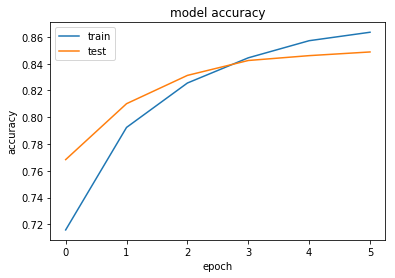

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



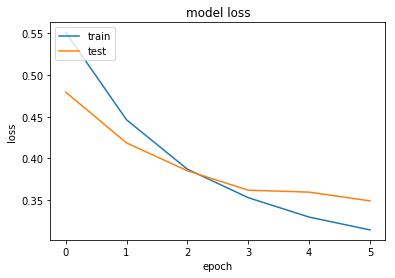

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [65]:
instance = X[798]
print(instance)

throw momma hasn t dated at all it s as funny now as when it was released a genuinely eccentric comedy that doesn t try too hard to be liked and is all the better for it full of memorable laugh out loud lines even small characters are well written and beautifully played like billy crystal s best friend s girlfriend and a lovely cameo from rob reiner as crystal s agent a little bit insane and a lot funny 


In [66]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.32088]], dtype=float32)

In [63]:
y[3]

1

In [78]:
from keras.layers import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [79]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          9432000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,496,257
Trainable params: 64,257
Non-trainable params: 9,432,000
_________________________________________________________________
None


In [80]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 19s 597us/step - loss: 0.4918 - acc: 0.7607 - val_loss: 0.4045 - val_acc: 0.8154
Epoch 2/6
32000/32000 [==============================] - 18s 564us/step - loss: 0.3609 - acc: 0.8418 - val_loss: 0.3746 - val_acc: 0.8334
Epoch 3/6
32000/32000 [==============================] - 18s 562us/step - loss: 0.3113 - acc: 0.8692 - val_loss: 0.3668 - val_acc: 0.8371
Epoch 4/6
32000/32000 [==============================] - 18s 555us/step - loss: 0.2748 - acc: 0.8884 - val_loss: 0.3544 - val_acc: 0.8427
Epoch 5/6
32000/32000 [==============================] - 18s 549us/step - loss: 0.2409 - acc: 0.9070 - val_loss: 0.3612 - val_acc: 0.8413
Epoch 6/6
10000/10000 [==============================] - 3s 265us/step


In [81]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3417175952911377
Test Accuracy: 0.8481


In [99]:
instance = X[3]
print(instance)

hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing dancing and singing the song one is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one


In [100]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.94163275]], dtype=float32)